# Analyse stock price changes during COP

In [1]:
from datetime import timedelta
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from pathlib import Path
import seaborn as sns
from scipy.stats import ttest_1samp, gstd, kstest, ttest_ind, kstwo
import statsmodels.api as sm

In [3]:
version = "17"
# This is a switch to allow investigation of multiple sets of companies. Valid options include:
# "renewable_all", "fossil_34", "constsust_34", "greencred_34",
# "renewable_20", "fossil_20", "constsust_20", "greencred_20"
# and a few assorted variables for one-off investigations.
filetype = "renewable_all"
# Do we want to plot each company's individual behaviour? 
plots_on = False
require_time_start = pd.to_datetime('2011-01-01')
# Do we want to include a period some days before/after the dictionary of events?
# You will need padding for 1-day events (e.g. OPEC meetings, IPCC reports, OilSpills)
padafter = 2
padbefore = 0
# If this variable is not empty/False, we switch to studing a different time series. 
# Options include None = COPs, "OilSpill", "OPEC", 
# "OPEC_28" (only 28 equally spaced OPEC meetings so stats are easier), "OPEC_Conference" 
# (only main conferences, not side meetings), OPEC_conf_28, "IPCC"
copOrOther = "OPEC_conf_28"
# If this is a string, we subtract some amount of the average fractional change in this filetype (usually constsust_20) 
# to make a linear model of the target variable before calculating statistics. This controls for unusual stock market activity.
norm_group = "constsust_34"

In [4]:
if copOrOther:
    output = f"./output/version{version}/{copOrOther}/{filetype}/before{padbefore}_after{padafter}_norm{norm_group}"
else:
    output = f"./output/version{version}/{filetype}/before{padbefore}_after{padafter}_norm{norm_group}"
Path(output).mkdir(exist_ok=True, parents=True)

In [5]:
output

'./output/version16/OPEC_conf_28/renewable_all/before0_after2_normconstsust_34'

In [6]:
# name of the relevant column in the company df. May be overwritten below depending on filetype. 
close = "Close"
# List of companies whose files we will read
if filetype == "renewable":
    companylist = [
        "0916.HK", "BEP", "EDPR.LS", "FSLR", "NEE", "NHPC.NS", "SUZLON.NS", "VWS.CO", "NPI.TO", "009830.KS"
    ]
elif filetype == "renewable_20":
    companylist = [
        "0916.HK", "BEP", "EDPR.LS", "FSLR", "NEE", "NHPC.NS", "SUZLON.NS", "VWS.CO", "NPI.TO", "009830.KS",
        "ORA", "3800.HK", "PLUG", "NDX1.F", "BLX.TO", "ECV.F", "SLR.MC", "S92.F", "VBK.F", "CSIQ", 
    ]
elif filetype == "fossil":
    companylist = [
        "XOM", "CVX", "SHEL", "601857.SS", "TTE", "COP", "BP", "PBR", "EQNR",  "600028.SS"
    ]
elif filetype == "fossil_20":
    companylist = [
        "XOM", "CVX", "SHEL", "601857.SS", "TTE", "COP", "BP", "PBR", "EQNR",  "600028.SS",
        "0883.HK", "SO", "ENB", "SLB", "DUK", "EOG", "CNQ", "EPD", "E", "OXY"
        
    ]
elif filetype == "constsust_20":
    companylist = ["ABT", "AMZN", "AZN", "BAC", "BRK-B", "COST", "GOOG", "JNJ", "JPM", "KO", 
                  "LLY", "MCD", "MRK", "NESN.SW", "NVO", "PEP", "PG", "ROG.SW", "TYT.L", "WMT"]
elif filetype == "control":
    companylist = ["AAPL", "AMZN", "BRK-B", "GOOG", "LLY", "MSFT", "NVDA", "TSM", "UNH", "V"]
elif filetype == "control_20":
    companylist = ["AAPL", "AMZN", "BRK-B", "GOOG", "LLY", "MSFT", "NVDA", "TSM", "UNH", "V",
                   "HD", "PG", "005930.KS", "MC.PA", "JNJ", "MA", "WMT", "AVGO", "NVO", "JPM"]
elif filetype == "oilprice":
    companylist = ["OilPrice"]
    close = "Adj Close**"
elif filetype == "tmp":
    companylist = ["^SPX"]
elif filetype == "oilfuturesApril":
    companylist = ["CrudeOilWTIFrontMonthApril"]
elif filetype == "greencred_20":
    companylist = ["005930.KS", "AAPL", "ACN", "ADBE", "AMD", "ASML", "AVGO", "CRM", "HD", "MA", 
                   "MC.PA", "MSFT", "NFLX", "NVDA", "NVS", "ORCL", "RMS.PA", "TMO", "UNH", "V"]
elif filetype == "dirty_20": 
    companylist = [
        'XOM', '600519.SS', 'CVX', 'KO', 'RELIANCE.NS',
        'SHEL', '601857.SS', 'WFC', '601288.SS', '601988.SS', 'BA', 'COP',
        'RIO', 'PBR', 'BP', '601088.SS', 'EQNR', 'MO', 'CNQ', 'ITC.NS'
    ]
else:
    companylist = os.listdir(f"./input/{filetype}/")
    companylist = [x[:-4] for x in companylist]
    # In these cases, we expect there to be more than 20 items
    if len(companylist) < 20:
        raise ValueError("Invalid filetype option")

In [7]:
if filetype[-2:] == "20":
    assert len(companylist) == 20

In [8]:
if norm_group:
    companynormlist = os.listdir(f"./input/{norm_group}/")
    companynormlist = [x[:-4] for x in companynormlist]
    # In these cases, we expect there to be more than 20 items
    if len(companynormlist) < 20:
        raise ValueError("Invalid filetype option")

In [9]:
if not copOrOther:
    copdates = pd.read_csv("./input/CopDates.txt", delimiter="|")
    copdates = copdates.iloc[:, 1:-1]
    copdates.columns = copdates.columns.str.replace('\s+', '')
    copdates["Start"] = pd.to_datetime(copdates["Start"])
    copdates["End"] = pd.to_datetime(copdates["End"])
    meetingstring = "COP number"
    copOrOtherLongstring  = "COP"
elif copOrOther == "OPEC":
    copdates = pd.read_csv("./input/OPEC_all_2002.csv", delimiter=",", parse_dates=["Date"])
    copdates["Start"] = copdates["Date"]
    copdates["End"] = copdates["Date"]
    meetingstring = f"OPEC meeting"
    copOrOtherLongstring = meetingstring
elif copOrOther == "OPEC_Conference":
    copdates = pd.read_csv("./input/OPEC_all_2002.csv", delimiter=",", parse_dates=["Date"])
    copdates["Start"] = copdates["Date"]
    copdates["End"] = copdates["Date"]
    copdates = copdates.drop_duplicates(subset=["Date"], keep="first")
    copdates = copdates.loc[["Meeting of the OPEC Conference" in i for i in copdates["Meeting Title"]]]
    copdates = copdates.reset_index(drop=True)
    meetingstring = f"OPEC meeting"
    copOrOtherLongstring = meetingstring
elif copOrOther == "OPEC_28":
    copdates = pd.read_csv("./input/OPEC_all_2002.csv", delimiter=",", parse_dates=["Date"])
    copdates["Start"] = copdates["Date"]
    copdates["End"] = copdates["Date"]
    copdates = copdates.drop_duplicates(subset=["Date"], keep="first")
    copdates = copdates.iloc[np.round(np.arange(0, len(copdates), (len(copdates) / 28 ))), :].reset_index()
    meetingstring = f"OPEC meeting"
    copOrOtherLongstring = meetingstring
elif copOrOther == "OPEC_conf_28":
    copdates = pd.read_csv("./input/OPEC_all_2002.csv", delimiter=",", parse_dates=["Date"])
    copdates["Start"] = copdates["Date"]
    copdates["End"] = copdates["Date"]
    copdates = copdates.loc[["Meeting of the OPEC Conference" in i for i in copdates["Meeting Title"]]]
    copdates = copdates.drop_duplicates(subset=["Date"], keep="first")
    copdates = copdates.iloc[np.round(np.arange(0, len(copdates), (len(copdates) / 28 ))), :].reset_index()
    meetingstring = f"OPEC meeting"
    copOrOtherLongstring = meetingstring
elif copOrOther == "OilSpill":
    copdates = pd.read_csv("./input/Oil spills data_v2.csv", delimiter=",", parse_dates=["Date"])
    copdates["Start"] = copdates["Date"]
    copdates["End"] = copdates["Date"]
    meetingstring = f"Oil spill"
    copOrOtherLongstring = meetingstring
elif copOrOther == "IPCC":
    copdates = pd.read_csv("./input/IPCC_dates.csv", delimiter=",", parse_dates=["Date"])
    copdates["Start"] = copdates["Date"]
    copdates["End"] = copdates["Date"]
    meetingstring = "IPCC report"
    copOrOtherLongstring = "IPCC report release"
else:
    raise ValueError("Did not specify a valid copOrOther")
if copOrOther:
    # In all cases, we can't allow duplicate dates so should  flush them out.
    copdates = copdates.drop_duplicates(subset=["Date"], keep="first")

In [10]:
if padbefore:
    copdates["Start"] = copdates["Start"] - timedelta(days=padbefore)
if padafter:
    copdates["End"] = copdates["End"] + timedelta(days=padafter)

# Loop over companies recording behaviour during COP or the same time gap shifted by some weeks

In [11]:
# This code reads the company data and inserts it into the lists aggregate_data and all_data.
# It does not return anything. 
# filetype is the folder with company data, 
# company is the name of the company data file, 
# maxweek is how many weeks before and after the COPs (or similar events) to consider the events.
def read_company_data(filetype, company, maxweek, aggregate_data, all_data):
    file_path = f'./input/{filetype}/{company}.csv'# Name of the variable denoting price at close

    # Read the data from the CSV file into a DataFrame
    df = pd.read_csv(file_path, parse_dates=['Date'])
    df = df[df["Open"] != "-"]
    df.iloc[:, 1:-1] = df.iloc[:, 1:-1].astype(float)
    if len(df[df[close] <= 0 ]) > 0:
        print("Contains negative values!")
        df = df[df[close] > 0 ]
    assert df["Date"].min() < require_time_start, f"Company {company} starts at {df['Date'].min()}, after {require_time_start}"
    df = df[np.isfinite(df[close])]
    # Label periods that are within COP. We consider the day after the close of COP to be included, since it is likely to end
    # on a weekend, and markets will close before final announcements are available.
    # We therefore go from the close of the market day nearest before to the close of the market day after COP.
    offset_results = {}
    for offset in [7*x for x in range(-maxweek, maxweek+1)]:
        copChange = []
        for num, row in copdates.iterrows():
            if (
                row["Start"] + pd.Timedelta(days=offset) > df["Date"].min()
            ) & (row["End"] + pd.Timedelta(days=offset) < df["Date"].max()
            ) & (sum(
                (df["Date"] >= row["Start"] + pd.Timedelta(days=offset)) & (df["Date"] <= row["End"] + pd.Timedelta(days=offset))
            ) > 1):
                copChange.append({
                    "COP": num, 
                    "Before": df.loc[
                        df["Date"] == max(df.loc[df["Date"] < row["Start"] + pd.Timedelta(days=offset), "Date"]), close
                    ].iloc[0],
                    "After":  df.loc[
                        df["Date"] == min(df.loc[df["Date"] > row["End"] + pd.Timedelta(days=offset), "Date"]), close
                    ].iloc[0],
                    "SD": df.loc[
                        (df["Date"] >= row["Start"] + pd.Timedelta(days=offset)) 
                            & ((df["Date"] <= row["End"] + pd.Timedelta(days=offset))), 
                        close
                    ].std(),
                    "geoSD": gstd(df.loc[
                        (df["Date"] >= row["Start"] + pd.Timedelta(days=offset)) 
                            & (df["Date"] <= row["End"] + pd.Timedelta(days=offset)), 
                        close
                    ]), 
                })
        copChange = pd.DataFrame(copChange)
        copChange["diff"] = (copChange["After"] - copChange["Before"]) / copChange["Before"]
        offset_results[offset/7] = copChange
    
    # Analyse the differences
    x = []
    ymean = []
    ystd = []
    yquant = {}
    ystdmean = []
    ygeostdmean = []
    quantiles = [0.1, 0.25, 0.5, 0.75, 0.9]
    for key, val in offset_results.items():
        x.append(key)
        ymean.append(val["diff"].mean())
        ystd.append(val["diff"].std())

        ystdmean.append(val["SD"].mean())
        ygeostdmean.append(val["geoSD"].mean())
        yquant[key] = np.quantile(val["diff"], quantiles)
        
    ymean = np.array(ymean)
    ystd = np.array(ystd)
    yquant = pd.DataFrame(yquant, index=quantiles)
    ystdmean = np.array(ystdmean)
    
    # construct illustrative statistics - firstly of the change during the period
    if plots_on:
        plt.figure()
        plt.plot(x, ymean*100)
        plt.fill_between(x, yquant.loc[0.25, :]*100, yquant.loc[0.75, :]*100, alpha=0.3)
        plt.fill_between(x, yquant.loc[0.9, :]*100, yquant.loc[0.1, :]*100, alpha=0.2)
        plt.xlabel("Weeks after COP starts")
        plt.ylabel("Average change during period (%)")
        plt.title(file_path.replace(".csv", ""))
        plt.legend(["Mean", "25-75%", "10-90%"])
        plt.savefig(f"{output}/ChangeIn_{company}.png")

        # Then of the standard deviation during the period
        plt.figure()
        plt.plot(x, ystdmean)
        plt.ylabel("Standard deviation during each period")
        plt.xlabel("Weeks after COP starts")
        plt.savefig(f"{output}/StDev_{company}.png")
    aggregate_data.append(
        pd.DataFrame({
            "company": company, "x": x, "ymean": ymean, 
            "ystd": ystd, "ystdmean": ystdmean, "ygeostdmean": ygeostdmean,
            "y0.1": yquant.loc[0.1,:], "y0.25": yquant.loc[0.25,:], 
            "y0.5": yquant.loc[0.5,:], "y0.75": yquant.loc[0.75,:], "y0.9": yquant.loc[0.9,:]
        })
    )
    for key, val in offset_results.items():
        val["offset"] = key
        val["company"] = company
        all_data.append(val)

In [12]:
aggregate_data = []
all_data = []
maxweek = 24
for company in companylist:
    read_company_data(filetype, company, maxweek, aggregate_data, all_data)

In [13]:
all_data = pd.concat(all_data)

In [14]:
alldata = pd.concat(aggregate_data)

In [15]:
def rowsubtract(df1, df2, frac, cols):
    # A somewhat specialised function to subtract the baseline data from each company for each date.
    # df1 is the baseline data, 
    # df2 is the normalisation data (cannot have a "company" column)
    # cols is a list of columns that should be joined on
    df = pd.merge(df1.reset_index(), df2, on=cols, suffixes=("_raw", "_norm")).set_index("index")
    for col in [c for c in df1.columns if (c not in cols) and c != "company"]:
        df[col] = df[col + "_raw"] - frac * df[col + "_norm"]
        df = df.drop([col + "_raw", col + "_norm"], axis=1)
    return df

In [16]:
if norm_group:
    aggregate_data_norm = []
    all_norm_data = []
    for company in companynormlist:
         read_company_data(norm_group, company, maxweek, aggregate_data_norm, all_norm_data)
    all_norm_data = pd.concat(all_norm_data)
    allnormsummarydata = pd.concat(aggregate_data_norm).groupby("x").mean()
    all_norm_data_grouped = all_norm_data.groupby(["COP", "offset"]).mean()

In [17]:
if norm_group:
    crosstable = pd.merge(all_data, all_norm_data, on=["COP", "offset"])
    model = sm.OLS(crosstable["diff_x"], sm.add_constant(crosstable["diff_y"]))
    results = model.fit()
    normfrac = results.params["diff_y"]
    alldata = rowsubtract(alldata, allnormsummarydata, normfrac, ["x"])
    all_data = rowsubtract(all_data, all_norm_data_grouped, normfrac, ["COP", "offset"])
    print(normfrac)

0.3862119026559649


C:\Users\rlamboll\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [19]:
compav = alldata.groupby("x").mean()
compmed = alldata.groupby("x").median()
compav.head()

,ymean,ystd,ystdmean,ygeostdmean,y0.1,y0.25,y0.5,y0.75,y0.9
x,,,,,,,,,
-24.0,0.002541,0.096158,7.435952,0.639717,-0.075159,-0.031479,-0.006166,0.024679,0.081910
-23.0,0.006244,0.069810,8.708981,0.635186,-0.061313,-0.031278,0.000620,0.038005,0.069882
-22.0,0.023896,0.097012,7.935188,0.643527,-0.067057,-0.021112,0.011401,0.063569,0.099545
-21.0,0.020291,0.084518,8.467873,0.640804,-0.049352,-0.024638,0.000744,0.045138,0.096400
-20.0,-0.005796,0.076983,8.375282,0.639443,-0.075853,-0.039052,-0.013345,0.019306,0.075483


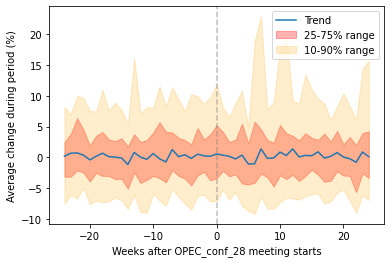

In [20]:
weeksafterstr = f"Weeks after {copOrOther + ' meeting' if copOrOther else 'COP'} starts"
plt.plot(compav.index, compmed.ymean*100)
plt.fill_between(compav.index, compav.loc[:, "y0.25"]*100, compav.loc[:, "y0.75"]*100, alpha=0.3, color="red")
plt.fill_between(compav.index, compav.loc[:, "y0.9"]*100, compav.loc[:, "y0.1"]*100, alpha=0.2, color="orange")

plt.axvline(x=0, color='grey', linestyle='--', alpha=0.5)
plt.ylabel("Average change during period (%)")
plt.xlabel(weeksafterstr)
plt.legend(["Trend", "25-75% range", "10-90% range"])
plt.savefig(f"{output}/AverageChange.png")

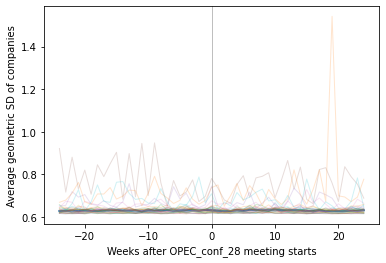

In [21]:
plt.plot(compmed.index, compmed.ygeostdmean, linewidth=2)
plt.ylabel("Average geometric SD of companies")
plt.xlabel(weeksafterstr)
for c in alldata.company.unique():
    plt.plot(alldata.loc[alldata.company==c, "x"], alldata.loc[alldata.company==c, "ygeostdmean"], alpha=0.2, linewidth=1)
plt.axvline(x=0, color='grey', linewidth=1, alpha=0.5)
plt.savefig(f"{output}/AverageStD.png")

In [22]:
companygeostdmean = alldata.groupby("company").mean().loc[:, ["ygeostdmean", "ystdmean"]]
companynorms = pd.merge(alldata, companygeostdmean.reset_index(), on="company").set_index("x")
normed_geostds = companynorms["ygeostdmean_x"] / companynorms["ygeostdmean_y"]
normedgroupedgeostds = normed_geostds.groupby(companynorms.index).mean()

In [23]:
normed_stds = companynorms["ystdmean_x"] / companynorms["ystdmean_y"]
normedgroupedstds = normed_stds.groupby(companynorms.index).mean()

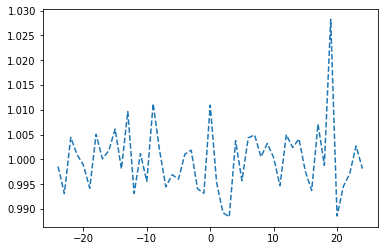

In [24]:
plt.plot(normedgroupedgeostds.index, normedgroupedgeostds, linestyle="--")

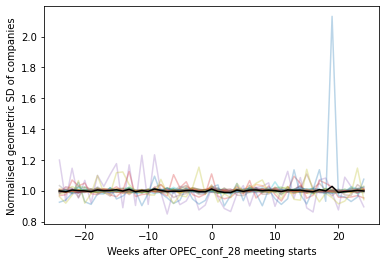

In [25]:
lenset = len(normed_geostds) / len(normedgroupedgeostds)
lencompany = len(normedgroupedgeostds)
for i in range(int(lenset)):
    plt.plot(
        normed_geostds.iloc[lencompany*i:lencompany*i+lencompany].index,
        normed_geostds.iloc[lencompany*i:lencompany*i+lencompany], 
        alpha=0.3
    )
plt.plot(normedgroupedgeostds.index, normedgroupedgeostds, color="black")
plt.ylabel("Normalised geometric SD of companies")
plt.xlabel(weeksafterstr)
plt.savefig(f"{output}/NormedAverageStD.png")

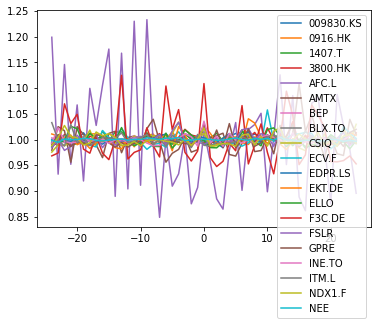

In [26]:
for i in range(20):
    plt.plot(
        normed_geostds.iloc[lencompany*i:lencompany*i+lencompany].index, 
        normed_geostds.iloc[lencompany*i:lencompany*i+lencompany], 
        alpha=1, 
        label=companygeostdmean.index[i]
    )
plt.legend()

In [27]:
definitelynotcops = all_data.loc[
        (all_data["offset"]!=0)&(all_data["offset"]!=1)&(all_data["offset"]!=-1)&(
            all_data["offset"]!=2)&(all_data["offset"]!=-2)&(all_data["offset"]!=3)&(all_data["offset"]!=-3),
    :]
distofcops = np.quantile(
    definitelynotcops["diff"],
    [0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95]
)
distofcopsGeoSD = np.quantile(
    definitelynotcops["geoSD"],
    [0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95]
)
distofcops = [i*100 for i in distofcops]

In [28]:
copnum = len(copdates)

In [29]:
copdates

,index,Date,Meeting Title,Start,End
0,0,2002-03-15,119th Meeting of the OPEC Conference,2002-03-15,2002-03-17
1,2,2002-09-19,121st Meeting of the OPEC Conference,2002-09-19,2002-09-21
2,5,2003-03-11,124th Meeting of the OPEC Conference,2003-03-11,2003-03-13
3,7,2003-06-11,125th (Extraordinary) Meeting of the OPEC Conf...,2003-06-11,2003-06-13
4,9,2003-09-24,127th Meeting of the OPEC Conference,2003-09-24,2003-09-26
5,12,2004-03-31,130th Meeting of the OPEC Conference,2004-03-31,2004-04-02
6,14,2004-09-15,132nd Meeting of the OPEC Conference,2004-09-15,2004-09-17
7,16,2005-01-30,134th (Extraordinary) Meeting of the OPEC Conf...,2005-01-30,2005-02-01
8,19,2005-09-19,137th Meeting of the OPEC Conference,2005-09-19,2005-09-21
9,21,2006-01-31,139th (Extraordinary) Meeting of the OPEC Conf...,2006-01-31,2006-02-02


In [30]:
inv = all_data.loc[all_data["offset"]==0, :].reset_index()
inv[inv["diff"]==inv["diff"].max()]

,index,COP,offset,company,Before,After,SD,geoSD,diff
257,5,15,0.0,GPRE,-7.400857,-4.788686,0.646088,0.862025,1.119408


In [31]:
inv[inv["COP"]==27]

,index,COP,offset,company,Before,After,SD,geoSD,diff
479,21,27,0.0,009830.KS,36193.856595,39433.814094,793.992914,0.629818,0.081844
480,6,27,0.0,0916.HK,-41.149287,-41.544083,-0.230740,0.637361,0.007450
481,16,27,0.0,1407.T,6286.916653,5966.684699,105.994952,0.627000,-0.057931
482,9,27,0.0,3800.HK,-53.986462,-54.796227,-0.666243,0.616717,-0.073752
483,15,27,0.0,AFC.L,-7.925437,5.446124,12.646183,0.854859,0.279336
484,12,27,0.0,AMTX,-37.965436,-42.113875,0.347928,0.676082,-0.195183
485,13,27,0.0,BEP,-24.413413,-26.679703,0.078114,0.633976,-0.058238
486,21,27,0.0,BLX.TO,-22.116981,-23.814404,-0.139450,0.625329,-0.038438
487,11,27,0.0,CSIQ,-18.785438,-24.413876,1.424468,0.672163,-0.139337
488,21,27,0.0,ECV.F,-40.670305,-42.067024,-0.138552,0.644214,-0.055402


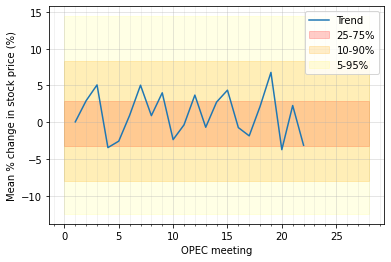

In [32]:
bycop = all_data.loc[all_data["offset"]==0, :].groupby("COP").mean()
plt.rcParams["xtick.minor.visible"] = True
plt.plot(bycop.reset_index(drop=True).index + 1, bycop["diff"] * 100)
plt.fill_between([0, copnum], [distofcops[2], distofcops[2]], [distofcops[4], distofcops[4]], alpha=0.2, color="red")
plt.fill_between([0, copnum], [distofcops[1], distofcops[1]], [distofcops[5], distofcops[5]], alpha=0.2, color="orange")
plt.fill_between([0, copnum], [distofcops[0], distofcops[0]], [distofcops[6], distofcops[6]], alpha=0.1, color="yellow")
plt.grid(True, which='minor', alpha=0.2)
plt.grid(True, which='major', alpha=0.4)
plt.xlabel(meetingstring)
plt.ylabel("Mean % change in stock price (%)")
plt.legend(["Trend", "25-75%", "10-90%", "5-95%"])
plt.savefig(f"{output}/ChangeinStockPricePerCOP.png")

In [33]:
copdates

,index,Date,Meeting Title,Start,End
0,0,2002-03-15,119th Meeting of the OPEC Conference,2002-03-15,2002-03-17
1,2,2002-09-19,121st Meeting of the OPEC Conference,2002-09-19,2002-09-21
2,5,2003-03-11,124th Meeting of the OPEC Conference,2003-03-11,2003-03-13
3,7,2003-06-11,125th (Extraordinary) Meeting of the OPEC Conf...,2003-06-11,2003-06-13
4,9,2003-09-24,127th Meeting of the OPEC Conference,2003-09-24,2003-09-26
5,12,2004-03-31,130th Meeting of the OPEC Conference,2004-03-31,2004-04-02
6,14,2004-09-15,132nd Meeting of the OPEC Conference,2004-09-15,2004-09-17
7,16,2005-01-30,134th (Extraordinary) Meeting of the OPEC Conf...,2005-01-30,2005-02-01
8,19,2005-09-19,137th Meeting of the OPEC Conference,2005-09-19,2005-09-21
9,21,2006-01-31,139th (Extraordinary) Meeting of the OPEC Conf...,2006-01-31,2006-02-02


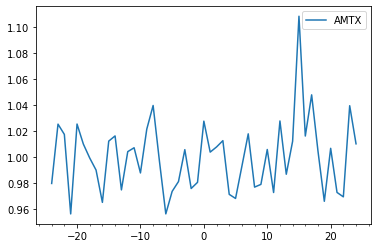

In [34]:
for i in range(5,6):
    plt.plot(
        normed_geostds.iloc[lencompany*i:lencompany*i+lencompany].index, 
        normed_geostds.iloc[lencompany*i:lencompany*i+lencompany], 
        alpha=1, 
        label=companygeostdmean.index[i]
    )
plt.legend()

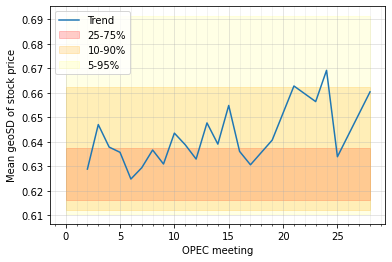

In [35]:
bycop = all_data.loc[all_data["offset"]==0, :].groupby("COP").mean()
plt.rcParams["xtick.minor.visible"] = True
plt.plot(bycop.index + 1, bycop["geoSD"])
plt.fill_between([0, copnum], [distofcopsGeoSD[2], distofcopsGeoSD[2]], [distofcopsGeoSD[4], distofcopsGeoSD[4]], alpha=0.2, color="red")
plt.fill_between([0, copnum], [distofcopsGeoSD[1], distofcopsGeoSD[1]], [distofcopsGeoSD[5], distofcopsGeoSD[5]], alpha=0.2, color="orange")
plt.fill_between([0, copnum], [distofcopsGeoSD[0], distofcopsGeoSD[0]], [distofcopsGeoSD[6], distofcopsGeoSD[6]], alpha=0.1, color="yellow")
plt.grid(True, which='minor', alpha=0.2)
plt.grid(True, which='major', alpha=0.4)
plt.xlabel(meetingstring)
plt.ylabel("Mean geoSD of stock price")
plt.legend(["Trend", "25-75%", "10-90%", "5-95%"])
plt.savefig(f"{output}/ChangeinGeoSDStockPricePerCOP.png")

In [36]:
def copnormfunction(all_data, offset1, distance):
    return all_data.loc[all_data["offset"]==offset1, :].groupby("COP").mean() - ( 
    all_data.loc[all_data["offset"]==offset1 - distance, :].groupby("COP").mean() + 
    all_data.loc[all_data["offset"]==offset1 + distance, :].groupby("COP").mean()
    ) * 0.5
linsubcop_length = 3

In [37]:
distofnormedmeans = pd.concat([
    copnormfunction(all_data, i, linsubcop_length) for i in 
    list(range(-maxweek+linsubcop_length, -1-linsubcop_length)) + list(range(3+linsubcop_length, maxweek-linsubcop_length+1))
])
quants_of_normedCOPs = np.nanquantile(distofnormedmeans["diff"],[0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95])
quants_of_normedCOPs = [i*100 for i in quants_of_normedCOPs]

In [ ]:
distofnormedmeans

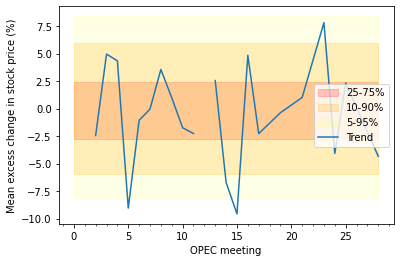

In [38]:
linsubcop = copnormfunction(all_data, 0, linsubcop_length)
plt.fill_between([0, copnum], [quants_of_normedCOPs[2], quants_of_normedCOPs[2]], [quants_of_normedCOPs[4], quants_of_normedCOPs[4]], alpha=0.2, color="red")
plt.fill_between([0, copnum], [quants_of_normedCOPs[1], quants_of_normedCOPs[1]], [quants_of_normedCOPs[5], quants_of_normedCOPs[5]], alpha=0.2, color="orange")
plt.fill_between([0, copnum], [quants_of_normedCOPs[0], quants_of_normedCOPs[0]], [quants_of_normedCOPs[6], quants_of_normedCOPs[6]], alpha=0.1, color="yellow")
plt.xlabel(meetingstring)
plt.plot(linsubcop.index + 1, linsubcop["diff"] * 100)
plt.ylabel("Mean excess change in stock price (%)")
plt.legend(["25-75%", "10-90%", "5-95%", "Trend"])
plt.savefig(f"{output}/NormedChangePerCop.png")

In [39]:
quants_of_normedCOPsGeoSD = np.nanquantile(distofnormedmeans["geoSD"],[0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95])
quants_of_normedCOPsGeoSD = [i*100 for i in quants_of_normedCOPsGeoSD]

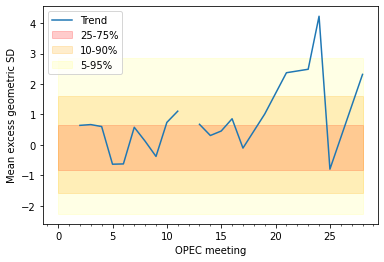

In [40]:
plt.plot(linsubcop.index + 1, linsubcop["geoSD"] * 100)
plt.fill_between([0, copnum], [quants_of_normedCOPsGeoSD[2], quants_of_normedCOPsGeoSD[2]], [quants_of_normedCOPsGeoSD[4], quants_of_normedCOPsGeoSD[4]], alpha=0.2, color="red")
plt.fill_between([0, copnum], [quants_of_normedCOPsGeoSD[1], quants_of_normedCOPsGeoSD[1]], [quants_of_normedCOPsGeoSD[5], quants_of_normedCOPsGeoSD[5]], alpha=0.2, color="orange")
plt.fill_between([0, copnum], [quants_of_normedCOPsGeoSD[0], quants_of_normedCOPsGeoSD[0]], [quants_of_normedCOPsGeoSD[6], quants_of_normedCOPsGeoSD[6]], alpha=0.1, color="yellow")
plt.xlabel(meetingstring)
plt.ylabel("Mean excess geometric SD")
plt.legend(["Trend", "25-75%", "10-90%", "5-95%"])
plt.savefig(f"{output}/NormedGeoSDPerCop.png")

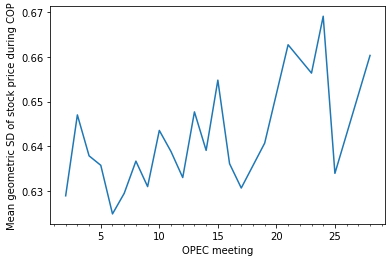

In [41]:
plt.plot(bycop.index + 1, bycop["geoSD"])
plt.xlabel(meetingstring)
plt.ylabel("Mean geometric SD of stock price during COP")
plt.savefig(f"{output}/GeometricSDPerCOP.png")

(array([  0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.

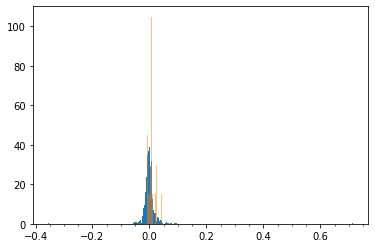

In [42]:
allgeosds = pd.concat([distofnormedmeans["geoSD"], linsubcop["geoSD"]])
bin_edges = np.histogram_bin_edges(allgeosds[~np.isnan(allgeosds)], bins='auto')
plt.hist(distofnormedmeans["geoSD"], density=True, bins=bin_edges)
plt.hist(linsubcop["geoSD"], density=True, bins=bin_edges, alpha=0.5)

(array([  0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.

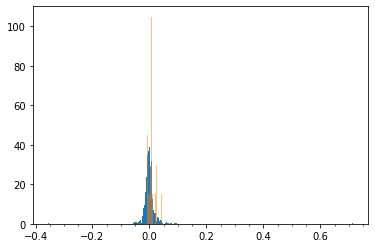

In [43]:
allgeosds = pd.concat([distofnormedmeans["geoSD"], linsubcop["geoSD"]])
bin_edges = np.histogram_bin_edges(allgeosds[~np.isnan(allgeosds)], bins='auto')
plt.hist(distofnormedmeans["geoSD"], density=True, bins=bin_edges)
plt.hist(linsubcop["geoSD"], density=True, bins=bin_edges, alpha=0.5)

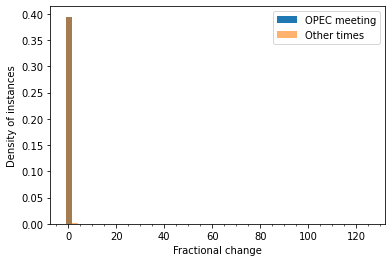

In [44]:
bin_edges = np.histogram_bin_edges(all_data["diff"], bins=50)
plt.hist(all_data[all_data.offset==0]["diff"], density=True, bins=bin_edges)
plt.hist(definitelynotcops["diff"], density=True, bins=bin_edges, alpha=0.6)
plt.xlabel("Fractional change")
plt.ylabel("Density of instances")
plt.legend([copOrOtherLongstring, "Other times"])
plt.savefig(f"{output}/HistogramOfDiffs.png")

In [45]:
alldata

,company,x,ymean,ystd,ystdmean,ygeostdmean,y0.1,y0.25,y0.5,y0.75,y0.9
index,,,,,,,,,,,
-24.0,009830.KS,-24.0,0.000516,0.048450,231.544038,0.628196,-0.067528,-0.011099,0.004393,0.019772,0.042941
-24.0,0916.HK,-24.0,0.019792,0.036994,-0.076938,0.618746,-0.011726,-0.002854,0.002929,0.052471,0.059286
-24.0,1407.T,-24.0,-0.023347,0.051360,4.995470,0.623276,-0.072459,-0.052590,-0.019077,-0.001987,0.027671
-24.0,3800.HK,-24.0,0.015593,0.057608,-0.123597,0.628939,-0.056849,0.005842,0.012970,0.040460,0.055740
-24.0,AFC.L,-24.0,-0.037386,0.405717,1.818706,0.921973,-0.438316,-0.144158,-0.061054,0.131666,0.501166
...,...,...,...,...,...,...,...,...,...,...,...
24.0,SLR.MC,24.0,0.012793,0.064940,-0.006012,0.630884,-0.072304,-0.033947,0.002955,0.051918,0.069348
24.0,SOL,24.0,0.004373,0.132143,1.142049,0.659336,-0.166505,-0.054156,-0.003333,0.071381,0.096459
24.0,SUZLON.NS,24.0,-0.004573,0.056225,1.850156,0.634695,-0.044350,-0.036020,-0.001980,0.026504,0.069071


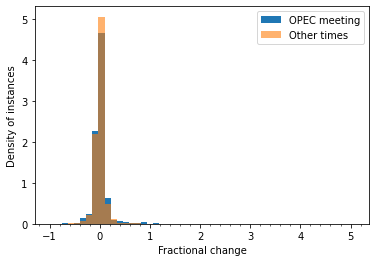

In [46]:
binlimithigh = all_data["diff"].mean() + 5 * all_data["diff"].std()
binlimitlow = all_data["diff"].mean() - 5 * all_data["diff"].std()
bindf = all_data.loc[(all_data["diff"] < binlimithigh) & (all_data["diff"] > binlimitlow), :]
bin_edges = np.histogram_bin_edges(bindf["diff"], bins=50)
plt.hist(bindf.loc[bindf.offset==0]["diff"], density=True, bins=bin_edges)
plt.hist(definitelynotcops.loc[
    (definitelynotcops["diff"] < binlimithigh) & (definitelynotcops["diff"]>binlimitlow), "diff"
], density=True, bins=bin_edges, alpha=0.6)
plt.xlabel("Fractional change")
plt.ylabel("Density of instances")
plt.legend([copOrOtherLongstring, "Other times"])
plt.savefig(f"{output}/HistogramOfDiffs_trunc.png")

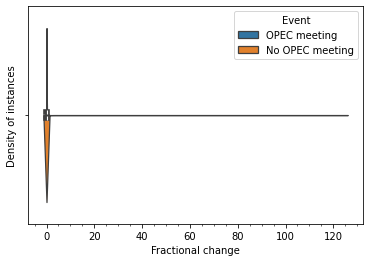

In [47]:
collected_data = pd.concat([
    pd.DataFrame({"Event": copOrOtherLongstring, "Difference": all_data[all_data.offset==0]["diff"]}), 
    pd.DataFrame({"Event": "No " + copOrOtherLongstring, "Difference": definitelynotcops["diff"]}), 
])
sns.violinplot(x=collected_data["Difference"], hue=collected_data["Event"], split=True)
plt.xlabel("Fractional change")
plt.ylabel("Density of instances")
plt.savefig(f"{output}/ViolinOfDiffs.png")

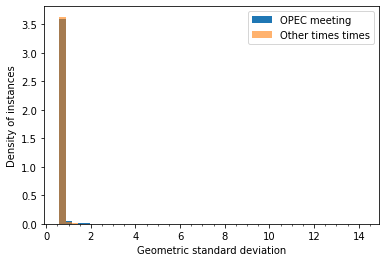

In [48]:
bin_edges = np.histogram_bin_edges(all_data["geoSD"], bins=50)
plt.hist(all_data[all_data.offset==0]["geoSD"], density=True, bins=bin_edges)
plt.hist(definitelynotcops["geoSD"], density=True, bins=bin_edges, alpha=0.6)
plt.xlabel("Geometric standard deviation")
plt.ylabel("Density of instances")
plt.legend([copOrOtherLongstring, "Other times times"])
plt.savefig(f"{output}/HistogramOfGeoSDs.png")

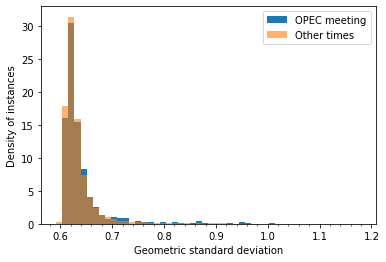

In [50]:
histogramdf = all_data
histlimit = 5*all_data["geoSD"].std() + all_data["geoSD"].mean()
histogramdf = histogramdf[histogramdf["geoSD"] < histlimit]
bin_edges = np.histogram_bin_edges(histogramdf["geoSD"], bins=50)
plt.hist(histogramdf[histogramdf.offset==0]["geoSD"], density=True, bins=bin_edges)
plt.hist(definitelynotcops.loc[definitelynotcops["geoSD"] < histlimit, "geoSD"], density=True, bins=bin_edges, alpha=0.6)
plt.xlabel("Geometric standard deviation")
plt.ylabel("Density of instances")
plt.legend([copOrOtherLongstring, "Other times"])
plt.savefig(f"{output}/HistogramOfGeoSDs_truncated.png")

In [51]:
histogramdf

,COP,offset,company,Before,After,SD,geoSD,diff
index,,,,,,,,
0,1,-24.0,009830.KS,4722.279177,5462.864938,-0.056334,0.611431,0.157054
0,1,-24.0,BLX.TO,-3.255481,-3.348065,-0.056334,0.611431,-0.024468
0,1,-24.0,ECV.F,-6.990000,-5.601634,0.054146,0.650199,0.692840
0,1,-24.0,EKT.DE,-5.729305,-5.705692,0.003834,0.630214,-0.007457
0,1,-24.0,ELLO,16.175564,11.324705,0.862904,0.650238,-0.194687
...,...,...,...,...,...,...,...,...
1,15,18.0,SIRC,1338.644485,1338.839719,-0.087679,0.610743,0.007429
4,15,18.0,SLR.MC,-8.304027,-8.133013,0.008224,0.644298,-0.000457
3,15,18.0,SOL,12.674953,12.120187,-0.016968,0.613877,-0.023756


In [52]:
histogramdf[histogramdf.offset==0]["geoSD"].mean()

0.6408058854605151

In [53]:
definitelynotcops["geoSD"].mean()

0.6377091220718923

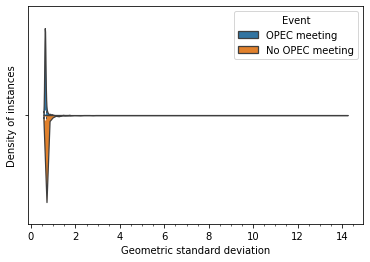

In [54]:
collected_data = pd.concat([
    pd.DataFrame({"Event": copOrOtherLongstring, "Difference": all_data[all_data.offset==0]["geoSD"]}), 
    pd.DataFrame({"Event": "No " + copOrOtherLongstring, "Difference": definitelynotcops["geoSD"]}), 
])
sns.violinplot(x=collected_data["Difference"], hue=collected_data["Event"], split=True)
plt.xlabel("Geometric standard deviation")
plt.ylabel("Density of instances")
plt.savefig(f"{output}/ViolinOfDiffs.png")

In [55]:
alldata[alldata["ymean"] >5]

,company,x,ymean,ystd,ystdmean,ygeostdmean,y0.1,y0.25,y0.5,y0.75,y0.9
index,,,,,,,,,,,
-13.0,NEL.OL,-13.0,6.758208,28.800721,4.606996,0.726951,-0.137009,-0.027873,0.054733,0.247204,0.813582
19.0,NEL.OL,19.0,6.609335,26.685684,613.345022,1.542404,-0.246177,-0.102182,-0.018822,0.045078,0.093455


In [56]:
all_data[all_data["geoSD"]==all_data["geoSD"].max()]

,COP,offset,company,Before,After,SD,geoSD,diff
index,,,,,,,,
3,9,19.0,NEL.OL,147.052663,17052.661394,9757.219122,14.226653,106.733217


In [57]:
definitelynotcops["geoSD"].max()

14.226653181786432

In [58]:
def cumdistplot(x, xlab, **kargs):
    n = len(x)
    x2 = np.sort(x)
    y = np.arange(n) / (n)
    plt.plot(x2, y, **kargs)
    plt.xlabel(xlab)
    plt.ylabel("Cumulative distribution")

In [59]:
companycorrelations = all_data.pivot(index=["COP", "offset"], columns="company", values="diff").corr()
companycorrelations[companycorrelations!=1].mean().mean()

0.09923102047403204

In [60]:
corracrosstimes = all_data[all_data["COP"]==15].pivot(index=["COP", "offset"], columns="company", values="diff").corr()
corracrosstimes[corracrosstimes!=1].mean().mean()

0.06377098059567801

In [61]:
corracrosstimes = all_data[all_data["COP"]==10].pivot(index=["COP", "offset"], columns="company", values="diff").corr()
corracrosstimes[corracrosstimes!=1].mean().mean()

0.03830888047317232

In [62]:
corracrosstimes = all_data[all_data["COP"]==25].pivot(index=["COP", "offset"], columns="company", values="diff").corr()
corracrosstimes[corracrosstimes!=1].mean().mean()

nan

In [63]:
all_data[all_data["COP"]==27].pivot(index=["COP", "offset"], columns="company", values="diff").T

COP              27                                                    \
offset        -24.0     -23.0     -22.0     -21.0     -20.0     -19.0   
company                                                                 
009830.KS  0.041624 -0.028716 -0.033177 -0.038102 -0.024691 -0.004023   
0916.HK   -0.031400 -0.033571 -0.035178 -0.007638 -0.006152 -0.031749   
1407.T    -0.017049  0.038774 -0.077369  0.188022 -0.051181       NaN   
3800.HK    0.003930 -0.003985 -0.001552 -0.003113  0.007382 -0.006392   
AFC.L     -0.024309  0.056770  0.091655 -0.290918 -0.135238  0.014207   
AMTX      -0.037465 -0.082402 -0.127930 -0.062337 -0.014887 -0.002339   
BEP       -0.029775  0.014660 -0.009763 -0.023036 -0.017665  0.010243   
BLX.TO     0.014134 -0.032963  0.021624 -0.039839  0.002360 -0.007446   
CSIQ       0.009174  0.194961 -0.073284 -0.017974 -0.094663 -0.010057   
ECV.F     -0.021006  0.031939  0.002750  0.009754 -0.079813  0.050963   
EDPR.LS   -0.017821  0.013606 -0.005599  0.037903 -0.048808  0.047415   
EKT.DE    -0.035693  0.046599  0.073815 -0.006469 -0.045339  0.020441   
ELLO      -0.040458  0.039771  0.005616 -0.029318 -0.035522  0.024306   
F3C.DE    -0.003617  0.099719 -0.092145 -0.034948 -0.069541  0.018136   
FSLR       0.030449  0.178842 -0.017523  0.030882 -0.097586 -0.022478   
GPRE      -0.018400  0.008195 -0.036238  0.037995 -0.023897  0.058691   
INE.TO     0.008136 -0.014954  0.031566 -0.023558 -0.035721 -0.007347   
ITM.L      0.006649  0.239493 -0.087604 -0.081225 -0.115303 -0.017134   
NDX1.F     0.002817  0.077982 -0.106505 -0.012230 -0.060720  0.003639   
NEE        0.016186  0.010048  0.012621 -0.003646  0.035835 -0.009761   
NEL.OL     0.017807  0.089422  0.149497 -0.245029 -0.109013 -0.019890   
NHPC.NS   -0.012676 -0.013261  0.019807 -0.008849  0.003551 -0.002494   
NPI.TO     0.006332  0.001542  0.009332 -0.008701  0.008082 -0.005005   
ORA        0.002602  0.036163 -0.004299  0.001816 -0.051601 -0.004782   
PLUG       0.026190 -0.000458 -0.037350 -0.119973 -0.058038  0.001426   
PNE3.DE   -0.002782  0.016313  0.001158 -0.015358 -0.034576 -0.002063   
REX        0.000564 -0.067751 -0.117452  0.056508 -0.094382  0.023451   
S92.F     -0.012783  0.091121 -0.003585  0.005951 -0.107987  0.022526   
SIRC      -0.108752  0.009460 -0.090008 -0.115850 -0.073197 -0.118526   
SLR.MC    -0.000810  0.002705 -0.034640  0.066357 -0.083965  0.063427   
SOL       -0.070538  0.192575 -0.084531 -0.047197 -0.103586 -0.043737   
SUZLON.NS  0.094208 -0.046668  0.201062 -0.054542 -0.030118 -0.019906   
VBK.F      0.013017 -0.072859  0.088973 -0.053552 -0.016081  0.175761   
VWS.CO     0.027802  0.011121 -0.015620 -0.012269 -0.070907  0.025382   

COP                                                ...                      \
offset        -18.0     -17.0     -16.0     -15.0  ...      15.0      16.0   
company                                            ...                       
009830.KS -0.093387  0.026509 -0.065724  0.003089  ...  0.004117 -0.015638   
0916.HK    0.260835 -0.061155 -0.066051  0.117604  ...  0.088226 -0.003167   
1407.T     0.015478 -0.085268 -0.045203  0.121750  ... -0.041355  0.070110   
3800.HK   -0.001189 -0.002100 -0.004166  0.001750  ...  0.093908 -0.020118   
AFC.L      0.562482  0.418831  0.278276  0.020489  ...  0.058227 -0.008276   
AMTX      -0.061664  0.066866 -0.070425 -0.014087  ... -0.029656  0.051993   
BEP        0.000361 -0.005708 -0.012469  0.063608  ... -0.018229 -0.018149   
BLX.TO     0.021776 -0.027610 -0.013880  0.019052  ... -0.033858 -0.001243   
CSIQ       0.039532 -0.020128 -0.121785 -0.015824  ...  0.142994 -0.045757   
ECV.F      0.031543  0.032965 -0.052644  0.058341  ... -0.003596  0.005759   
EDPR.LS   -0.011931 -0.019424  0.005542  0.065090  ... -0.010326 -0.004370   
EKT.DE     0.007740 -0.007381 -0.044874  0.014295  ...  0.033461 -0.004370   
ELLO      -0.039943 -0.025068 -0.004166 -0.000423  ...  0.031176 -0.020980   
F3C.DE    -0.377308  0.228504 -0.009816  0.068164 

In [64]:
corracrosstimes = all_data[all_data["offset"]==16].pivot(index=["COP", "offset"], columns="company", values="diff").T.corr()
corracrosstimes[corracrosstimes!=1].mean().mean()

0.0519142298845968

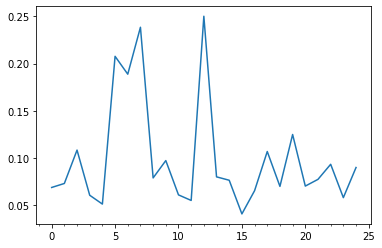

In [65]:
correlmap = {}
for i in range(28):
    correlsacrosscops = all_data[all_data["offset"]==i].pivot(index=["COP", "offset"], columns="company", values="diff").corr()
    correlmap[i] = correlsacrosscops[correlsacrosscops!=1].mean().mean()
plt.plot(correlmap.keys(), correlmap.values())

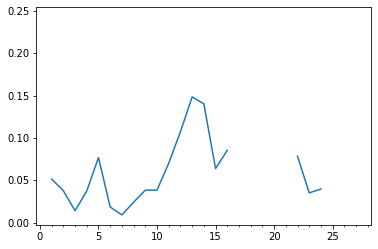

In [66]:
correlmap = {}
for i in range(28):
    corracrosstimes = all_data[all_data["COP"]==i].pivot(index=["COP", "offset"], columns="company", values="diff").corr()
    correlmap[i] = corracrosstimes[corracrosstimes!=1].mean().mean()
plt.plot(correlmap.keys(), correlmap.values())

In [67]:
correlsacrosscops = all_data[all_data["offset"]==5].pivot(index=["COP", "offset"], columns="company", values="diff").corr()
correlsacrosscops[correlsacrosscops!=1].mean().mean()

0.20771131429667222

In [68]:
correlsacrosscops = all_data[all_data["offset"]==10].pivot(index=["COP", "offset"], columns="company", values="diff").corr()
correlsacrosscops[correlsacrosscops!=1].mean().mean()

0.061036118935750734

In [69]:
correlsacrosscops = all_data[all_data["offset"]==-10].pivot(index=["COP", "offset"], columns="company", values="diff").corr()
correlsacrosscops[correlsacrosscops!=1].mean().mean()

0.027054177131101934

In [70]:
all_data[all_data["offset"]==-10].pivot(index=["COP", "offset"], columns="company", values="diff")

,company,009830.KS,0916.HK,1407.T,3800.HK,AFC.L,AMTX,BEP,BLX.TO,CSIQ,ECV.F,...,PLUG,PNE3.DE,REX,S92.F,SIRC,SLR.MC,SOL,SUZLON.NS,VBK.F,VWS.CO
COP,offset,,,,,,,,,,,,,,,,,,,,,
1,-10.0,0.017249,NaN,NaN,NaN,NaN,NaN,NaN,-0.006597,NaN,-0.012358,...,-0.068424,-0.045221,-0.047842,NaN,NaN,NaN,NaN,NaN,NaN,-0.036555
2,-10.0,0.072903,NaN,NaN,NaN,NaN,NaN,NaN,-0.028236,NaN,0.007517,...,0.046712,0.098413,0.082443,NaN,NaN,NaN,NaN,NaN,NaN,-0.005799
3,-10.0,0.067151,NaN,NaN,NaN,NaN,NaN,NaN,-0.030236,NaN,-0.016536,...,0.012211,-0.060015,0.003872,NaN,NaN,NaN,NaN,NaN,NaN,0.135768
4,-10.0,-0.068351,NaN,NaN,NaN,NaN,NaN,NaN,-0.040271,NaN,0.037143,...,-0.079363,-0.086256,-0.022079,NaN,NaN,NaN,NaN,NaN,NaN,0.025332
5,-10.0,0.041724,NaN,NaN,NaN,NaN,NaN,NaN,-0.005085,NaN,-0.005085,...,-0.058622,0.030630,0.018418,NaN,NaN,NaN,NaN,NaN,NaN,0.014333
6,-10.0,0.094434,NaN,-0.023505,NaN,NaN,NaN,NaN,-0.031723,NaN,0.029456,...,-0.071057,-0.045411,-0.013389,NaN,NaN,NaN,NaN,NaN,NaN,-0.042358
7,-10.0,0.043568,NaN,0.009511,NaN,NaN,NaN,NaN,0.029256,NaN,0.063246,...,-0.010915,-0.014518,0.006799,NaN,NaN,NaN,NaN,NaN,NaN,0.023567
8,-10.0,-0.002039,NaN,0.038005,NaN,NaN,NaN,NaN,0.000168,NaN,-0.025415,...,-0.040907,-0.018714,0.035357,NaN,NaN,NaN,NaN,NaN,NaN,-0.018387
9,-10.0,-0.003555,NaN,-0.018707,NaN,NaN,NaN,0.061333,-0.002363,NaN,-0.026632,...,0.036686,-0.095222,0.019371,NaN,NaN,NaN,NaN,0.016604,NaN,-0.251327


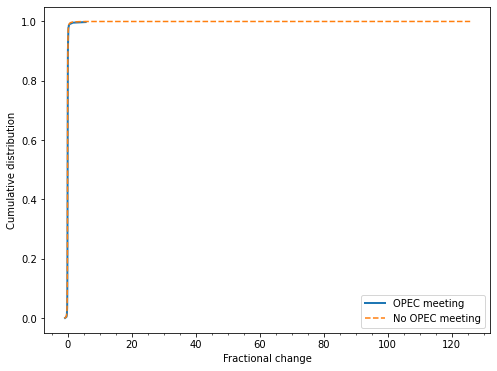

In [71]:
plt.figure(figsize=(8, 6))
cumdistplot(all_data[all_data.offset==-7]["diff"], linewidth=2, xlab="Fractional change")
cumdistplot(definitelynotcops["diff"], linestyle="--", xlab="Fractional change")
plt.legend([copOrOtherLongstring, "No " + copOrOtherLongstring])

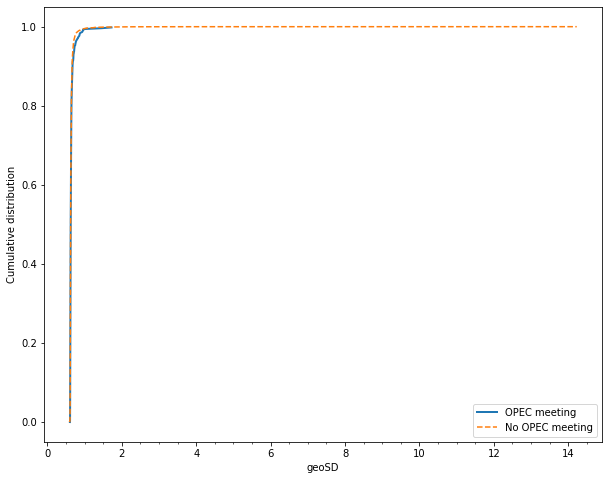

In [72]:
plt.figure(figsize=(10, 8))
cumdistplot(all_data[all_data.offset==0]["geoSD"], xlab="geoSD", linewidth=2)
cumdistplot(definitelynotcops["geoSD"], xlab="geoSD", linestyle="--")
plt.legend([copOrOtherLongstring, "No " + copOrOtherLongstring])

In [73]:
# define some functions to caluclate the probability using only rank information
def relative_rank(values, target_value, rel=False):
    assert type(target_value) == type(0.0)
    # Sort the values in ascending order
    sorted_values = sorted(values.append(pd.Series(target_value, index=[0])))
    # Get the relative rank of the target value
    rank = sorted_values.index(target_value) + 1
    if rel:
        rank = rank / (len(values) + 1)
    return rank
def calc_prob_from_rank(values, target_value):
    # values are the array of observations in general, target value is the putatively extreme value
    rankv = relative_rank(values, target_value)
    # Converts a ranking into a probability using Jenkinson's Formula
    # See Estimating Changing Extremes Using Empirical Ranking Methods
    # Formula is (rank - 0.31) / (N + 0.38). 
    return (rankv - 0.31) / (len(values) + 1.38) 

In [74]:
all_data[all_data.offset==0]

,COP,offset,company,Before,After,SD,geoSD,diff
index,,,,,,,,
0,1,0.0,009830.KS,2694.217827,2543.679205,-0.075623,0.608747,-0.039243
0,1,0.0,BLX.TO,-3.996085,-3.699771,-0.049250,0.617052,0.012170
0,1,0.0,ECV.F,-4.763573,-4.452341,-0.075623,0.608747,0.016594
0,1,0.0,EKT.DE,-6.154114,-5.691194,0.046960,0.711365,0.141595
0,1,0.0,ELLO,4.732378,1.443610,-0.004912,0.615537,-0.280926
...,...,...,...,...,...,...,...,...
10,27,0.0,SLR.MC,-40.225437,-40.998875,-0.111392,0.645015,-0.016337
9,27,0.0,SOL,-49.825437,-51.763875,-0.014320,0.730859,-0.197405
13,27,0.0,SUZLON.NS,-50.435672,-50.926378,-0.615979,0.619858,0.014348


In [75]:
def calculate_covariance(group, col="diff"):
    # Calculate covariance matrix
    covariance_matrix = group[col].cov(group[col])
    return covariance_matrix

In [76]:
# Effective sample size is suppressed due to correlations between data at each time. The true mathematics of this is complicated,
# but we approximate it through N_eff = N * (covariance) / sigma**2
n_effective_ratio = (
    all_data.pivot(index=('COP', "offset"), columns="company", values='diff').std() ** 2
).sum() / all_data.pivot(index=('COP', "offset"), columns="company", values='diff').cov().sum().sum()
n_effective_ratio

0.9775229457103222

In [78]:
# Sanity-check that this is similar to normalising by std using the correlation rather than covariance
len((all_data.pivot(index=('COP', "offset"), columns="company", values='diff')).corr()) / all_data.pivot(index=('COP', "offset"), columns="company", values='diff').corr().sum().sum()

0.23393872206763658

In [79]:
# Construct a dataframe of the results of KS test and student-T test for 2 samples comparing these populations
# We report the uncorrected data, but also the data after correcting for correlation between observations
KSdiff = kstest(all_data[all_data.offset==0]["diff"], definitelynotcops["diff"])
KSgeoSD = kstest(all_data[all_data.offset==0]["geoSD"], definitelynotcops["geoSD"])
tdiff = ttest_ind(all_data[all_data.offset==0]["diff"], definitelynotcops["diff"])
tgeoSD = ttest_ind(all_data[all_data.offset==0]["geoSD"], definitelynotcops["geoSD"])
# Now calculate using the effective number of independent values
nks1 = len(all_data[all_data.offset==0]["diff"])
nks2 = len(definitelynotcops["diff"])
KSdiffcorrel = kstwo.sf(KSdiff.statistic, int((nks1*nks2)/(nks1+nks2)*n_effective_ratio))
KSgeoSDcorrel = kstwo.sf(KSgeoSD.statistic, int((nks1*nks2)/(nks1+nks2)*n_effective_ratio))

higeosd = 5*all_data["geoSD"].std() + all_data["geoSD"].mean()
logeosd = -5*all_data["geoSD"].std() + all_data["geoSD"].mean()
hidiff = 5*all_data["diff"].std() + all_data["diff"].mean()
lodiff = -5*all_data["diff"].std() + all_data["diff"].mean()

truncatedtdiff = ttest_ind(
     [x for x in all_data[all_data.offset==0]["diff"] if (x < hidiff) & (x>lodiff)], 
    [x for x in definitelynotcops["diff"] if (x < hidiff) & (x>lodiff)]
)
truncatedtgeoSD = ttest_ind(
    [x for x in all_data[all_data.offset==0]["geoSD"] if (x < higeosd) & (x > logeosd)], 
    [x for x in definitelynotcops["geoSD"] if (x < higeosd) & (x > logeosd)]
)
kstest_results = pd.DataFrame({
    "Test": ["KSDiff", "KSDiffcorrel", "KSgeoSD", "KSgeoSDcorrel", "t-Diff", "t-geoSD", "t-Diff-truncated", "t-geoSD-truncated", "meandiff", "mediandiff"], 
    "testStat": [KSdiff[0], KSdiff[0], KSgeoSD[0], KSgeoSD[0], tdiff[0], tgeoSD[0], truncatedtdiff[0], truncatedtgeoSD[0],
                 all_data[all_data.offset==0]["diff"].mean() - definitelynotcops["diff"].mean(),
                 all_data[all_data.offset==0]["diff"].median() - definitelynotcops["diff"].median(),
                ], 
    "pval": [KSdiff[1], KSdiffcorrel, KSgeoSD[1], KSgeoSDcorrel, tdiff[1], tgeoSD[1], truncatedtdiff[1], truncatedtgeoSD[1], 1, 1], 
})
ranktest = pd.DataFrame({
    "Test": ["RankTestDiff", "RankTestgeoSD"], 
    "testStat": [
        relative_rank(
            definitelynotcops.groupby("offset").mean()["diff"], all_data[all_data.offset==0]["diff"].mean(), rel=True
        ), 
        relative_rank(
            definitelynotcops.groupby("offset").mean()["geoSD"], all_data[all_data.offset==0]["geoSD"].mean(), rel=True
        )
    ],
    "pval": [
        calc_prob_from_rank(definitelynotcops.groupby("offset").mean()["diff"], all_data[all_data.offset==0]["diff"].mean()),
        calc_prob_from_rank(definitelynotcops.groupby("offset").mean()["geoSD"], all_data[all_data.offset==0]["geoSD"].mean()),
    ]
})
kstest_results = kstest_results.append(ranktest)
if norm_group:
    kstest_results = kstest_results.append(pd.DataFrame({
        "Test": ["Normalised"], 
        "testStat": [norm_group],
        "pval": [normfrac]
    }))
kstest_results.to_csv(f"{output}/Kolmogorov_Smirnoff_test_results.csv")
kstest_results

,Test,testStat,pval
0,KSDiff,0.042255,0.323584
1,KSDiffcorrel,0.042255,0.337559
2,KSgeoSD,0.068039,0.018435
3,KSgeoSDcorrel,0.068039,0.020604
4,t-Diff,-0.208491,0.834848
5,t-geoSD,1.303992,0.192250
6,t-Diff-truncated,0.215943,0.829034
7,t-geoSD-truncated,3.604771,0.000313
8,meandiff,-0.010558,1.000000
9,mediandiff,0.000085,1.000000


In [80]:
output

'./output/version16/OPEC_conf_28/renewable_all/before0_after2_normconstsust_34'